# 微调 BERT 模型

In this example, we will work through fine-tuning a BERT model using the tensorflow-models PIP package.
在这个例子中，我们将使用 tensorflow-models PIP 包来微调一个 BERT 模型。

The pretrained BERT model this tutorial is based on is also available on [TensorFlow Hub](https://tensorflow.org/hub), to see how to use it refer to the [Hub Appendix](#hub_bert)
本教程使用的预训练过的 BERT 模型也可以在[TensorFlow Hub](https://tensorflow.org/hub) 上获得，想知道如何使用请参考[Hub Appendix](#hub_bert)。

## Setup 设置

### 安装 TensorFlow Model Garden pip 包

*  `tf-models-nightly` 是个每天自动生成的 nightly Model Garden 包。
*  pip 将会自动安装所有的模型及依赖项。

In [2]:
!pip install -q tf-nightly
!pip install -q tf-models-nightly

### 引入

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

/tmpfs/src/tf_docs_env/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:44: UserWarning: You are currently using a nightly version of TensorFlow (2.3.0-dev20200623). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


### 资源

这个目录中包含了此教程需要的配置、词汇表和一个预训练好的检查点：

In [4]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

您可以从 TensorFlow Hub 中得到一个预训练过的 BERT 编码器：

In [5]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

## 数据
在这个例子中我们将使用 [GLUE MRPC dataset from TFDS](https://www.tensorflow.org/datasets/catalog/glue#gluemrpc).

此数据集还未设置，所以它能直接喂进BERT模型中，因此在此节我们也需要进行一些必要的预处理。

### 从 TensorFlow Datasets 中获取数据集

The Microsoft Research Paraphrase Corpus (Dolan & Brockett, 2005) 是一个从在线新闻资源中自动提取的句子对的语料库，并且由人工来注释这些句子对是否在语义上相同。

*   标签数量: 2.
*   训练集的大小: 3668.
*   验证集的大小: 408.
*   训练集与验证集中句子的最大长度: 128.


In [6]:
glue, info = tfds.load('glue/mrpc', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:860: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/lib/python3/dist-packages/urllib3/connectionpool.py:860: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/lib/python3/dist-packages/urllib3/connectionpool.py:860: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/glue/mrpc/1.0.0.incomplete1RTRDK/glue-train.tfrecord
Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/glue/mrpc/1.0.0.incomplete1RTRDK/glue-validation.tfrecord
Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/glue/mrpc/1.0.0.incomplete1RTRDK/glue-test.tfrecord
Dataset glue downloaded and prepared to /home/kbuilder/tensorflow_datasets/glue/mrpc/1.0.0. Subsequent calls will reuse this data.


In [7]:
list(glue.keys())

['test', 'train', 'validation']

 对象 `info` 描述了数据集及其特征(features):

In [8]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

这两类（标签）是:

In [9]:
info.features['label'].names

['not_equivalent', 'equivalent']

这是一个训练集的示例:

In [10]:
glue_train = glue['train']

for key, value in glue_train.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


###  BERT 词典（tokenizer）

要微调一个预训练模型，您需要确保使用与训练期间完全相同的 标记(tokenization)、词汇表(vocabulary) 和 索引映射(index mapping)。

本教程中使用的 BERT 词典 是由纯 Python 编写的（不是由 TensorFlow 的操作得来），所以你不能像使用 `preprocessing.TextVectorization` 一样把它作为一个 `keras.layer` 插入模型中。

以下代码重建了基础模型使用的字典:

In [11]:
# 建立字典来生成Tensorflow数据集
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


编码一个句子:

In [12]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


### 预处理数据

本节将手动处理数据集为模型需要的格式。

该数据集很小，因此处理数据可以在内存中快速、轻松地完成。对于更大的数据集， `tf_models` 库中包括了一些用来处理和重新序列化的工具，可在 [Appendix: Re-encoding a large dataset](#re_encoding_tools) 查看更多细节。

#### 编码句子

该模型希望输入的两个句子被连接在一起，输入被期望以标记 `[CLS]` "This is a classification problem" 开始，并且每个句子应该以一个`[SEP]` "Separator" 标记结束：

In [13]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

首先编码所有的句子并以标记 `[SEP]` 结尾，并把他们打包到不规则张量(ragged-tensors)中：

In [14]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence1 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence1"]])
sentence2 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence2"]])

In [15]:
print("Sentence1 shape:", sentence1.shape.as_list())
print("Sentence2 shape:", sentence2.shape.as_list())

Sentence1 shape: [3668, None]
Sentence2 shape: [3668, None]


现在添加一个`[CLS]`标记，并连接不规则张量(ragged tensors)来为每个示例形成一个单独的 `input_word_ids` 张量。使用`RaggedTensor.to_tensor()`将不规则张量(ragged tensors)用 0 填充至最长句子长度。

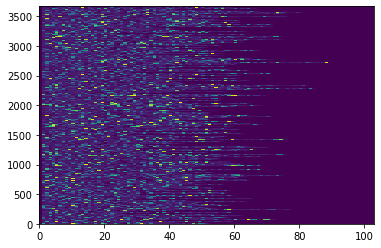

In [16]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

#### Mask and input type 掩码(mask)和输入类型

该模型需要两个额外的输入：

* 输入掩码
* 输入类型

掩码使得模型能够清楚地区分出内容和填充，掩码的形状与`input_word_ids`相同，并且在 `input_word_ids` 中非填充的位置值为`1`。 

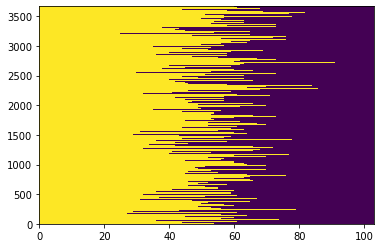

In [17]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

 "输入类型(input type)" 也有相同的形状，但在非填充的位置包含了 `0` 或 `1` 指示标记(token)是哪个句子内容。

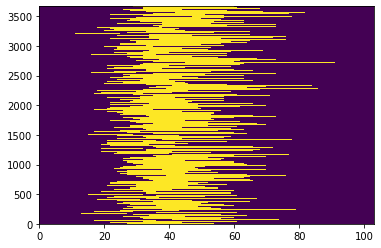

In [18]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

#### 将它们打包

将上述的文本解析代码放入一个函数中，然后将其应用到 `glue/mrpc` 数据集的每一部分。

In [19]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence1"])
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence1"])])
  sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(glue_dict["sentence2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [20]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

每个数据集的子数据集都被转换到一个关于特征(feature)的字典(dictionary)和一组标签。每个输入字典的特征都有相同的形状，并与标签的数量匹配。

In [21]:
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (3668, 103)
input_mask      shape: (3668, 103)
input_type_ids  shape: (3668, 103)
glue_train_labels shape: (3668,)


##  模型

###  建立模型


第一步是下载预训练模型的配置。

In [22]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

 `config` 定义了核心 BERT 模型, 这是一个从最大句子长度为`max_seq_length`的输入中预测输出 `num_classes` 的 Keras 模型。

此函数同时返回编码器和分类器。

In [23]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

此分类器有三个输入和一个输出：

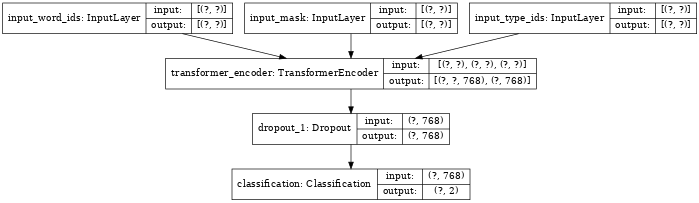

In [24]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

在一个包含10个示例的训练集批次中运行它，输出为两个分类的logits：

In [25]:
glue_batch = {key: val[:10] for key, val in glue_train.items()}

bert_classifier(
    glue_batch, training=True
).numpy()

array([[ 0.05488977, -0.26042116],
       [ 0.11358108, -0.09727937],
       [ 0.14350253, -0.2465629 ],
       [ 0.2775127 , -0.09028438],
       [ 0.3606584 , -0.17138724],
       [ 0.3287397 , -0.14672714],
       [ 0.18621178, -0.13080403],
       [ 0.21898738,  0.10716071],
       [ 0.18413854, -0.13491377],
       [ 0.20307963, -0.05396855]], dtype=float32)

上方分类器中心的 `TransformerEncoder` **即** `bert_encoder`。

检查编码器，我们可以看到它的一堆 `Transformer` 层连接到相同的三个输入：

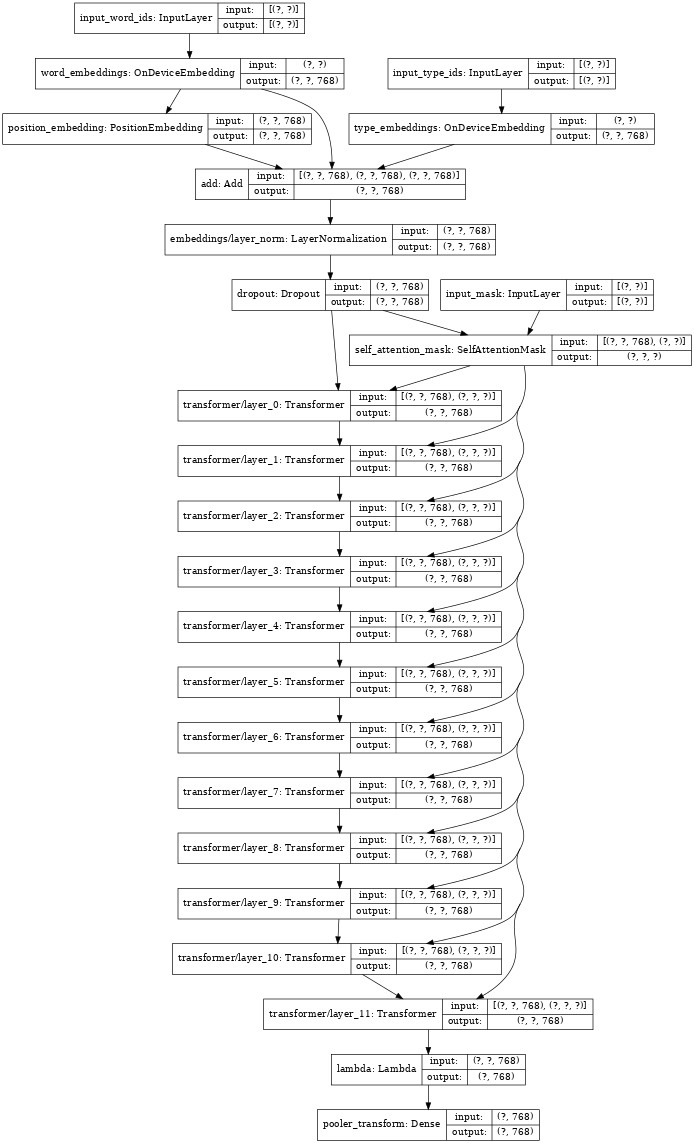

In [26]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

### 恢复编码器权重(weights)

随机初始化编码器后，从检查点中恢复编码器的权重：

In [27]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

注意：预训练的 `TransformerEncoder` 也可以在 [TensorFlow Hub](https://tensorflow.org/hub) 上取得，在 [Hub appendix](#hub_bert) 查看更多细节。

### 设置优化器

BERT 采用权重衰减的 Adam 优化器 (又名 "[AdamW](https://arxiv.org/abs/1711.05101)").
它也采用了学习率规划(learning rate schedule)，即(学习率)从0开始预热，然后又衰减至0。

In [28]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# 使用学习率规划建立优化器
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

它将返回一个设置了学习率规划(learning rate schedule)的`AdamWeightDecay` 优化器：

In [29]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

想知道如何自定义一个优化器及其规划(schedule)，可查看 [Optimizer schedule appendix](#optiizer_schedule)。

### 训练模型

度量标准是准确度，我们使用稀疏分类交叉熵(sparse categorical cross-entropy)来计算损失。

In [30]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/3
115/115 [==============================] - 25s 218ms/step - loss: 0.7047 - accuracy: 0.6101 - val_loss: 0.5219 - val_accuracy: 0.7181
Epoch 2/3
115/115 [==============================] - 24s 210ms/step - loss: 0.5068 - accuracy: 0.7560 - val_loss: 0.5047 - val_accuracy: 0.7794
Epoch 3/3
115/115 [==============================] - 24s 209ms/step - loss: 0.3812 - accuracy: 0.8332 - val_loss: 0.4839 - val_accuracy: 0.8137


现在在自定义的示例上运行这个微调模型来看看它如何工作。

首先对一些句子对进行编码：

In [31]:
my_examples = bert_encode(
    glue_dict = {
        'sentence1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.'],
        'sentence2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.']
    },
    tokenizer=tokenizer)

此模型应该对第一个示例报告分类 `1` (匹配)，对第二个示例报告 `0`(不匹配)：

In [32]:
result = bert_classifier(my_examples, training=False)

result = tf.argmax(result).numpy()
result

array([1, 0])

In [33]:
np.array(info.features['label'].names)[result]

array(['equivalent', 'not_equivalent'], dtype='<U14')

### 保存模型

通常我们训练模型的目标是将其用于某些用途，因此我们输出模型然后恢复它来确保它能使用。

In [34]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [35]:
reloaded = tf.saved_model.load(export_dir)
reloaded_result = reloaded([my_examples['input_word_ids'],
                            my_examples['input_mask'],
                            my_examples['input_type_ids']], training=False)

original_result = bert_classifier(my_examples, training=False)

# The results are (nearly) identical:
print(original_result.numpy())
print()
print(reloaded_result.numpy())

[[-1.1238481   0.92107666]
 [ 0.35722053 -0.4061358 ]]

[[-1.1238478   0.9210764 ]
 [ 0.35722044 -0.40613574]]


## 附录

<a id=re_encoding_tools></a>
### 重编码一个大型数据集

为清楚起见，本教程在内存中对数据集进行编码。

因为 `glue/mrpc` 是个非常小的数据集所以才能这样。`tf_models` 库包含了一些工具来处理和重编码更大的数据集以进行有效地训练。

第一步是描述数据集的哪些特征应该进行转换：

In [36]:
processor = nlp.data.classifier_data_lib.TfdsProcessor(
    tfds_params="dataset=glue/mrpc,text_key=sentence1,text_b_key=sentence2",
    process_text_fn=bert.tokenization.convert_to_unicode)

然后应用这些转换来生成新的TFRecord文件。

In [37]:
# 建立 Tensorflow 训练集和验证集的输出
train_data_output_path="./mrpc_train.tf_record"
eval_data_output_path="./mrpc_eval.tf_record"

max_seq_length = 128
batch_size = 32
eval_batch_size = 32

# 生成并保存训练集至 tf record 文件
input_meta_data = (
    nlp.data.classifier_data_lib.generate_tf_record_from_data_file(
      processor=processor,
      data_dir=None,  # 此项为 `None` 因为数据来自于 tfds，而不是本地目录
      tokenizer=tokenizer,
      train_data_output_path=train_data_output_path,
      eval_data_output_path=eval_data_output_path,
      max_seq_length=max_seq_length))

最后从TFRecord文件中创建 `tf.data` 输入管道(pipelines)：

In [38]:
training_dataset = bert.run_classifier.get_dataset_fn(
    train_data_output_path,
    max_seq_length,
    batch_size,
    is_training=True)()

evaluation_dataset = bert.run_classifier.get_dataset_fn(
    eval_data_output_path,
    max_seq_length,
    eval_batch_size,
    is_training=False)()


正如`keras.Model.fit`所期望的，生成的 `tf.data.Datasets` 将返回`(features, labels)`对：

In [39]:
training_dataset.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

#### 创建用于训练和评估的tf.data.Dataset


如果您需要修改数据集加载部分，以下是一些入门代码：

In [40]:
def create_classifier_dataset(file_path, seq_length, batch_size, is_training):
  """从(tf)records文件中为 训练/评估 创建输入数据集"""
  dataset = tf.data.TFRecordDataset(file_path)
  if is_training:
    dataset = dataset.shuffle(100)
    dataset = dataset.repeat()

  def decode_record(record):
    name_to_features = {
      'input_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
      'input_mask': tf.io.FixedLenFeature([seq_length], tf.int64),
      'segment_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
      'label_ids': tf.io.FixedLenFeature([], tf.int64),
    }
    return tf.io.parse_single_example(record, name_to_features)

  def _select_data_from_record(record):
    x = {
        'input_word_ids': record['input_ids'],
        'input_mask': record['input_mask'],
        'input_type_ids': record['segment_ids']
    }
    y = record['label_ids']
    return (x, y)

  dataset = dataset.map(decode_record,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      _select_data_from_record,
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size, drop_remainder=is_training)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

In [41]:
# 设置批大小
batch_size = 32
eval_batch_size = 32

# 返回 Tensorflow 数据集
training_dataset = create_classifier_dataset(
    train_data_output_path,
    input_meta_data['max_seq_length'],
    batch_size,
    is_training=True)

evaluation_dataset = create_classifier_dataset(
    eval_data_output_path,
    input_meta_data['max_seq_length'],
    eval_batch_size,
    is_training=False)

In [42]:
training_dataset.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

<a id="hub_bert"></a>

### TFHub上的TFModels BERT

You can get [the BERT model](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) off the shelf from [TFHub](https://tensorflow.org/hub). It would not be hard to add a classification head on top of this `hub.KerasLayer`
您可以从 [TFHub](https://tensorflow.org/hub)中获得 [the BERT model](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2)，在`hub.KerasLayer`上添加一个分类head并不难。

In [43]:
# Note: 350MB download.
import tensorflow_hub as hub
hub_encoder = hub.KerasLayer(hub_url_bert, trainable=True)

print(f"The Hub encoder has {len(hub_encoder.trainable_variables)} trainable variables")

The Hub encoder has 199 trainable variables


测试运行一批数据：

In [44]:
result = hub_encoder(
    inputs=[glue_train['input_word_ids'][:10],
            glue_train['input_mask'][:10],
            glue_train['input_type_ids'][:10],],
    training=False,
)

print("Pooled output shape:", result[0].shape)
print("Sequence output shape:", result[1].shape)

Pooled output shape: (10, 768)
Sequence output shape: (10, 103, 768)


此时您可以轻松添加一个分类head。

`bert_models.classifier_model`函数也能在 TensorFlow Hub 的编码器中建立一个分类器。

In [45]:
hub_classifier, hub_encoder = bert.bert_models.classifier_model(
    # 注意：如果您传递一个hub链接，大部分的`bert_config` 会被忽略。
    bert_config=bert_config, hub_module_url=hub_url_bert, num_labels=2)

从TFHub中加载此模型的一个缺点是内部 keras 层的结构没有恢复，所以查看或修改模型会变得更困难，现在， `TransformerEncoder` 模型是一个单独的层。

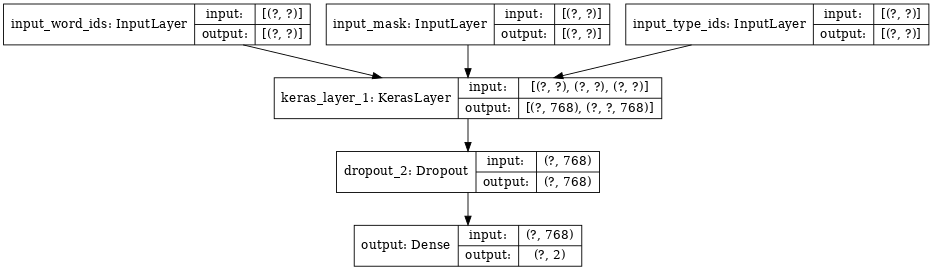

In [46]:
tf.keras.utils.plot_model(hub_classifier, show_shapes=True, dpi=64)

In [47]:
try:
  tf.keras.utils.plot_model(hub_encoder, show_shapes=True, dpi=64)
  assert False
except Exception as e:
  print(f"{type(e).__name__}: {e}")

AttributeError: 'KerasLayer' object has no attribute 'layers'


<a id="model_builder_functions"></a>

### 低层模型建立

如果您需要对模型的结构有更多的控制，则值得注意的是，之前使用的`classifier_model` 函数只是 `nlp.modeling.networks.TransformerEncoder` 和 `nlp.modeling.models.BertClassifier` 类的简单的装饰器(wrapper)。只需记住如果您开始修改结构，则可能在重载预训练检查点时出错，所以您可能需要从头开始进行训练。

构建编码器:

In [48]:
transformer_config = config_dict.copy()

# You need to rename a few fields to make this work:
transformer_config['attention_dropout_rate'] = transformer_config.pop('attention_probs_dropout_prob')
transformer_config['activation'] = tf_utils.get_activation(transformer_config.pop('hidden_act'))
transformer_config['dropout_rate'] = transformer_config.pop('hidden_dropout_prob')
transformer_config['initializer'] = tf.keras.initializers.TruncatedNormal(
          stddev=transformer_config.pop('initializer_range'))
transformer_config['max_sequence_length'] = transformer_config.pop('max_position_embeddings')
transformer_config['num_layers'] = transformer_config.pop('num_hidden_layers')

transformer_config

{'hidden_size': 768,
 'intermediate_size': 3072,
 'num_attention_heads': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522,
 'attention_dropout_rate': 0.1,
 'activation': <function official.modeling.activations.gelu.gelu(x)>,
 'dropout_rate': 0.1,
 'initializer': <tensorflow.python.keras.initializers.initializers_v2.TruncatedNormal at 0x7f81145cb3c8>,
 'max_sequence_length': 512,
 'num_layers': 12}

In [49]:
manual_encoder = nlp.modeling.networks.TransformerEncoder(**transformer_config)

恢复权重:

In [50]:
checkpoint = tf.train.Checkpoint(model=manual_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

测试运行:

In [51]:
result = manual_encoder(my_examples, training=True)

print("Sequence output shape:", result[0].shape)
print("Pooled output shape:", result[1].shape)

Sequence output shape: (2, 23, 768)
Pooled output shape: (2, 768)


将其包装在分类器中:

In [52]:
manual_classifier = nlp.modeling.models.BertClassifier(
        bert_encoder,
        num_classes=2,
        dropout_rate=transformer_config['dropout_rate'],
        initializer=tf.keras.initializers.TruncatedNormal(
          stddev=bert_config.initializer_range))

In [53]:
manual_classifier(my_examples, training=True).numpy()

array([[-0.22512403,  0.07213479],
       [-0.21233292,  0.1311737 ]], dtype=float32)

<a id="optiizer_schedule"></a>

###  优化器和规划(schedules)

用来训练模型的优化器由`nlp.optimization.create_optimizer` 函数创建：

In [54]:
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

高层的装饰器设置了学习率规划（learning rate schedules）和优化器。

此处使用的基本的学习率规划是在训练过程中线性衰减至0：

In [55]:
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs

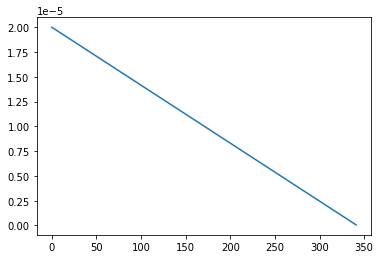

In [56]:
decay_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=2e-5,
      decay_steps=num_train_steps,
      end_learning_rate=0)

plt.plot([decay_schedule(n) for n in range(num_train_steps)])

这又被包含在一个学习率在前10%的训练中线性递增至目标值的`WarmUp`规划中：

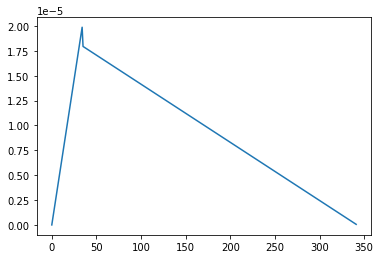

In [57]:
warmup_steps = num_train_steps * 0.1

warmup_schedule = nlp.optimization.WarmUp(
        initial_learning_rate=2e-5,
        decay_schedule_fn=decay_schedule,
        warmup_steps=warmup_steps)

# 这个 warmup 超过了目标(overshoot)，因为它会根起始的设置预热到 `initial_learning_rate`
# 如果您不想让它超过目标，可以设置`initial_learning_rate=decay_schedule(warmup_steps)` 
plt.plot([warmup_schedule(n) for n in range(num_train_steps)])

然后使用此规划为BERT模型的配置生成`nlp.optimization.AdamWeightDecay`:

In [58]:
optimizer = nlp.optimization.AdamWeightDecay(
        learning_rate=warmup_schedule,
        weight_decay_rate=0.01,
        epsilon=1e-6,
        exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'])